# Models for Complex Systems final project
## Authors
Tobias Schiolborg, 
Lars Kæraa Lücke, 
Hróbjartur Höskuldsson, 
Johannes Brøns Christensen, 
Sara Denner Vincent Larsen
# 
modified by Tobias Schiolborg

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns


from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from itertools import product
import time

# Part 1: Simulation
## Plotting each Xi from Ex_1.csv
First we will show what the data looks like. Here we look at alle of the Xis from single file 

In [2]:
df1 = pd.read_csv('data/Ex_1.csv')
df1.head()

,t,X1,X2,X3,X4,X5,X6,X7,X8
0,1,2,1,1,0,3,4,0,9
1,2,8,6,0,7,4,1,5,6
2,3,3,4,3,7,1,4,7,2
3,4,4,7,0,2,7,7,4,6
4,5,0,6,4,6,2,4,10,8


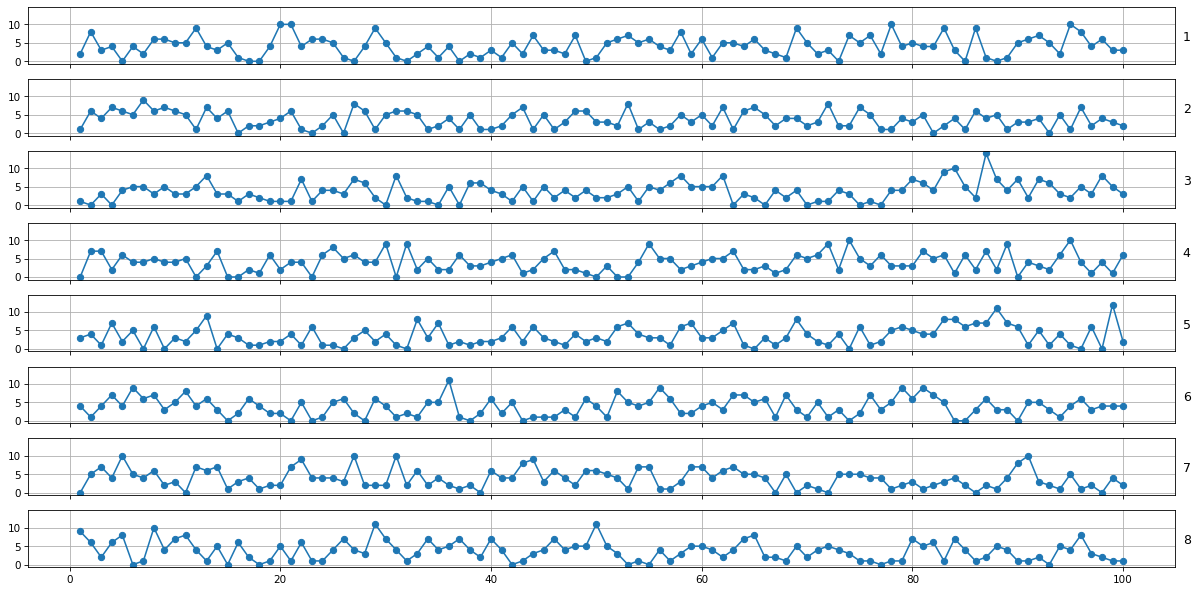

In [3]:
n = 8

max_x = int(df1.iloc[:,1:].to_numpy().max())
fig, ax = plt.subplots(n, figsize=(16, 8), dpi=75, sharex=True, sharey=True)
ax[0].set_yticks(range(0, max_x, 5))

for i in range(n):
    ax[i].set_title(i+1, x=1.01, y=0.3)
    ax[i].plot(df1.t, df1.iloc[:,1+i], 'o-')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

# Plotting mean of Xs for each file
Each subplot above corresponds to a single a single Xi, and each point shows its value over time.

For each i, every point $X_{t,i}$ is derived from the same Ct. So it makes sense to take the mean of the values at each t. Such that we get:

$Xmean_t = 1/10 \sum_i( X_{t,i} )$

This is done for each of the 10 files

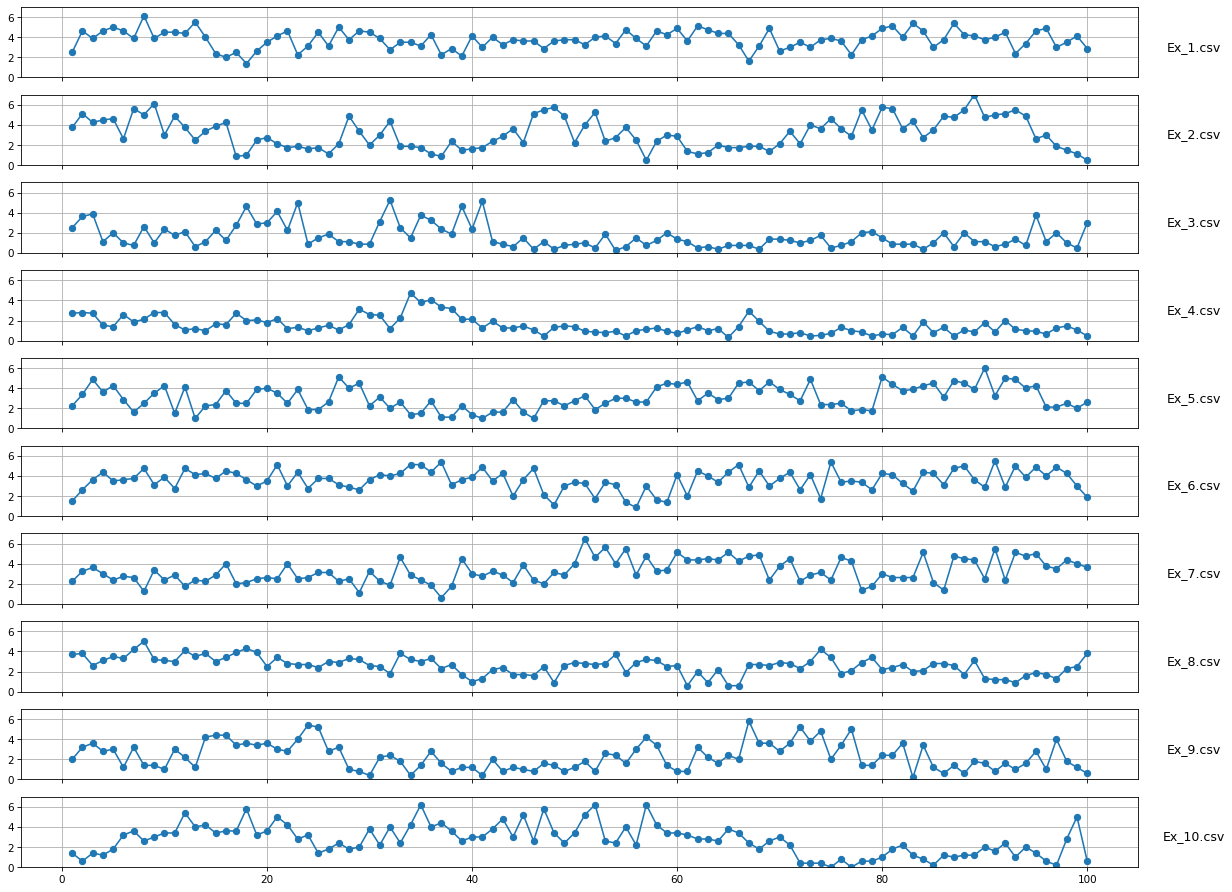

In [ ]:
def plot_data_mean():
    n = 10 # Changed n to 10
    y_max = 7 # I guess this is for nicer plots, but would be cool with a derived max mean value
    
    fig, ax = plt.subplots(n, figsize=(16, 12), dpi=75, sharex=True, sharey=True)
    ax[0].set_yticks(range(0, y_max, 2))
    ax[0].set_ylim(0, y_max)
    
    for i in range(n):
        df = pd.read_csv(f'data/Ex_{i+1}.csv')
        df['avg'] = df.iloc[:,1:].mean(axis=1)
        
        ax[i].set_title(f'Ex_{i+1}.csv', x=1.05, y=0.3)
        ax[i].plot(df.t, df.avg, 'o-')
        ax[i].grid(True)
        
    plt.tight_layout()
    plt.show()
plot_data_mean()

# Simulating data
A function to simulate X, Z and C is now created. This corresponds to the first task in part I.

The parameter $m$ is added to create multiple sets of data.

The parameters alpha, beta, gamma, lam0 and lam1 has to either a single value or a list of values with dimension = $m$.

C is contructed first since everything depends on C. We have that $C_{t+1}$ is dependant on $C_t$, so we start by setting $C_0$ to 2 and then using a for-loop to set the remaining values, which is the part with the v0, v1 and v2.

.

When $C_t=0$ we have that

$P(C_{t+1}=0 | C_t=0) = 1-\gamma \ \ \ \ \ P(C_{t+1}=1 | C_t=0) = 0 \ \ \ \ \  P(C_{t+1}=2 | C_t=0) = \gamma$

which corresponds to v0.

.

When $C_t=1$ we have that

$P(C_{t+1}=0 | C_t=1) = 0 \ \ \ \ \ P(C_{t+1}=1 | C_t=1) = 1-\gamma \ \ \ \ \  P(C_{t+1}=2 | C_t=1) = \gamma$

which corresponds to v1.

.

When $C_t=2$ we have that

$P(C_{t+1}=0 | C_t=2) = \beta/2 \ \ \ \ \ P(C_{t+1}=1 | C_t=2) = \beta/2 \ \ \ \ \  P(C_{t+1}=2 | C_t=2) = 1-\beta$

which corresponds to v2.

.

We then compute $Z_t$ which each consists of n independent values given $C_t$. We have the distribution:

$P(Z_{t,i}=1 | C_t=0) = 1-\alpha \ \ \ \ \ P(Z_{t,i}=1 | C_t=1) = \alpha \ \ \ \ \  P(Z_{t,i}=1 | C_t=2) = 0.5$

.

Finally $X$ can be computed. We have that each $X_{t,i}$ is independent given $Z_{t,i}$. Each $X_{t,i}$ is a poisson distribution with parameter $lambda = \lambda_0$ if $Z_{t,i}=0$ and $lambda = \lambda_1$ if $Z_{t,i}=1$.

In [3]:
# this function is just made to check the input parameters, and to transform alpha, beta, gamma, lam0, lam1 into arrays of size m 
def check_values(n, T, m, alpha, beta, gamma, lam0, lam1):
    assert(n > 0)
    assert(T > 0)
    assert(m > 0)
    
    # make all to numpy arrays:
    args = locals()
    for c,v in list(args.items())[3:]:
        v = np.array(v)
        assert(v.shape in [(),(m,)])
        if v.shape == ():
            v = np.ones(m) * v
        args[c] = v
    
    assert(all(args['alpha'] > 0.5))
    assert(all(args['alpha'] < 1))
    assert(all(args['beta'] > 0))    
    assert(all(args['beta'] < 1))
    assert(all(args['gamma'] > 0))
    assert(all(args['gamma'] < 1))
    assert(all(args['lam0'] > 0))
    assert(all(args['lam1'] > 0))
    
    return args['alpha'], args['beta'], args['gamma'], args['lam0'], args['lam1']


def hmm_sim(n=10, T=100, m=1, alpha=0.9, beta=0.2, gamma=0.1, lam0=1, lam1=5):
    alpha, beta, gamma, lam0, lam1 = check_values(n, T, m, alpha, beta, gamma, lam0, lam1)
    
    C = np.zeros(shape=(m,T))
    C[:,0] = 2
    
    for i in range(1,T):
        v0 = (C[:,i-1] == 0) * (np.random.binomial(1, p=gamma, size=m) * 2)
        v1 = (C[:,i-1] == 1) * (np.random.binomial(1, p=gamma, size=m) + 1)
        v2 = np.random.binomial(1, p=1-beta, size=m)
        v2 = (v2 == 0) * np.random.binomial(1, p=0.5, size=m) + v2*2
        v2 = (C[:,i-1] == 2) * v2
        C[:,i] = v0 + v1 + v2
    
    p = np.reshape((C == 0) * (1-alpha[:, np.newaxis]) + (C == 1) * alpha[:, np.newaxis] + (C == 2) * 0.5, (m,T,1))
    Z = np.random.binomial(1, p, size=(m,T,n))
    
    X = np.random.poisson((Z == 0)*lam0[:, np.newaxis, np.newaxis] + Z*lam1[:, np.newaxis, np.newaxis])
    return X,Z,C

X1,Z1,C1 = hmm_sim(n=10,T=5,m=2)
print(C1)
print(Z1)
print(X1)

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]
[[[0 1 0 1 0 1 1 1 1 0]
  [1 0 0 1 1 0 0 0 1 1]
  [1 0 1 0 1 1 1 0 1 0]
  [1 0 1 1 1 0 0 0 1 0]
  [0 0 1 1 1 1 1 0 1 0]]

 [[0 0 1 0 1 0 1 0 0 0]
  [0 0 1 1 1 0 1 1 1 0]
  [0 1 0 1 1 0 1 1 0 1]
  [0 1 1 0 0 1 1 0 0 0]
  [0 1 0 1 0 1 1 0 1 1]]]
[[[ 3  2  1  4  0  8  5  1  5  1]
  [ 8  0  0  6  5  1  0  1  6  5]
  [ 5  1  6  0  8  4  4  1  2  0]
  [ 8  1  8  3  5  2  1  0  4  0]
  [ 1  2  5  7  9  5  3  1 10  0]]

 [[ 3  1  5  2  7  1  6  2  1  1]
  [ 0  2  2  1  5  2  4  6  1  1]
  [ 2  3  1  6  6  0  5  6  0  5]
  [ 1  3  7  0  3  3  1  0  1  0]
  [ 0  2  0  7  1  4  4  2  8  5]]]


# Plotting simulated data
The X values are plotted similarly as before, such that the mean value of X for a given t is computed. 

Z and C will also be plotted if given. The mean of Z for a given t is computed. Then we get two points for each t (for a single plot), one corresponding to the mean of Xt and one to the mean of Zt.

The value of Z is scaled with the maximum of all means of Xt, and each is colored corresponding to the value of C.

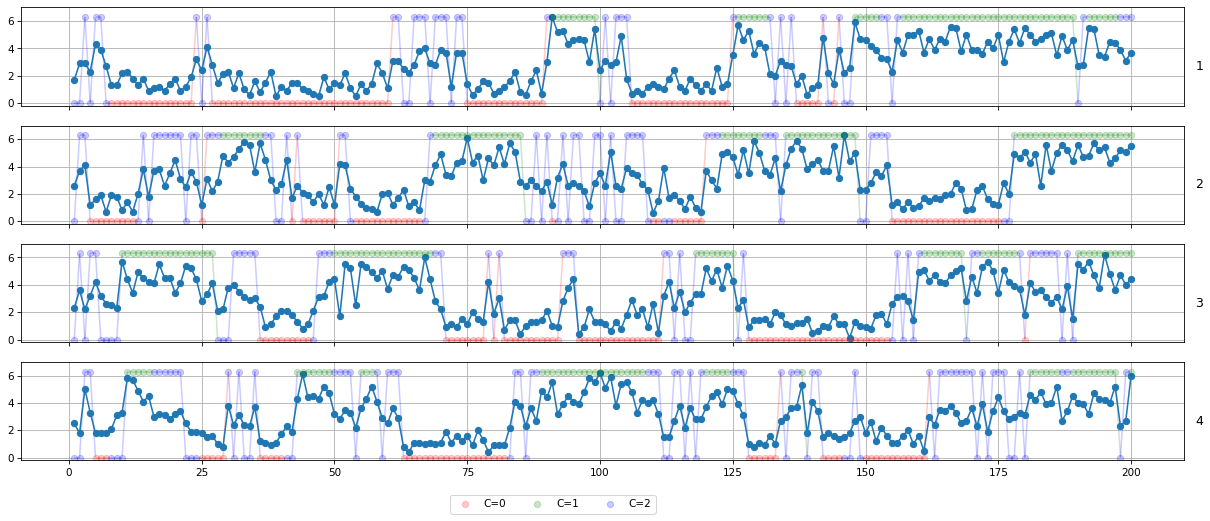

In [ ]:
def plot_sim(X, Z=None, C=None, mode='o-', alpha=0.2, titles=None):
    # X, Z and C can be either 3d numpy arrays or list of 2d numpy arrays
    m = len(X)
    T,n = X[0].shape
    x_mean = [X[i].mean(axis=1) for i in range(m)]
    x_max = max([x_mean[i].max() for i in range(m)])
    
    if titles is None: titles = range(1,m+1)
    
    if Z is not None and C is not None: 
        z_mean = [(Z[i].mean(axis=1)+0.5).astype(int) * x_max for i in range(m)]
        color_dict = {0:'red', 1:'green', 2:'blue'}
        cols = np.vectorize(color_dict.get)(C)
        z_mean_0 = [np.ma.masked_where(C[i] != 0, z_mean[i]) for i in range(m)]
        z_mean_1 = [np.ma.masked_where(C[i] != 1, z_mean[i]) for i in range(m)]
        z_mean_2 = [np.ma.masked_where(C[i] != 2, z_mean[i]) for i in range(m)]
    
    fig, ax = plt.subplots(m, figsize=(20, m*2), dpi=75, sharex=True, sharey=True, squeeze=False)
    ax = ax[:,0]
    ax[0].set_yticks(range(0, int(x_max+1), int(x_max/5+1)))
    ax[0].set_ylim(-0.2, int(x_max+1))
    
    for i in range(m):
        ax[i].set_title(titles[i], x=1.01, y=0.3, loc='left')
        ax[i].plot(range(1,T+1), x_mean[i], mode)
        
        if Z is not None and C is not None:
            # add lines of Z in colors corresponding to C
            if '-' in mode:
                points = np.array([list(range(1,T+1)), z_mean[i]]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, colors=cols[i], alpha=alpha)
                ax[i].add_collection(lc)
            
            # add dots
            if 'o' in mode:
                a, = ax[i].plot(range(1,T+1), z_mean_0[i], 'o', c=color_dict[0], alpha=alpha, label='C=0')
                b, = ax[i].plot(range(1,T+1), z_mean_1[i], 'o', c=color_dict[1], alpha=alpha, label='C=1')
                c, = ax[i].plot(range(1,T+1), z_mean_2[i], 'o', c=color_dict[2], alpha=alpha, label='C=2')
                
        ax[i].grid(True)
    
    if Z is not None and C is not None and 'o' in mode:
        plt.legend(handles=[a,b,c], bbox_to_anchor=(0.55, -0.3), ncol=3)
    plt.show()
    
plot_sim(*hmm_sim(n=10,T=200,m=4))

Below, I have shown some different plots with a higher value of n and T. T increases the number of points, while n gives us a better mean.

Plot 2: alpha is decreased

Plot 3: beta is increased

Plot 4: gamma is increased

Plot 5: lam0 is increased

Plot 6: lam1 is increased

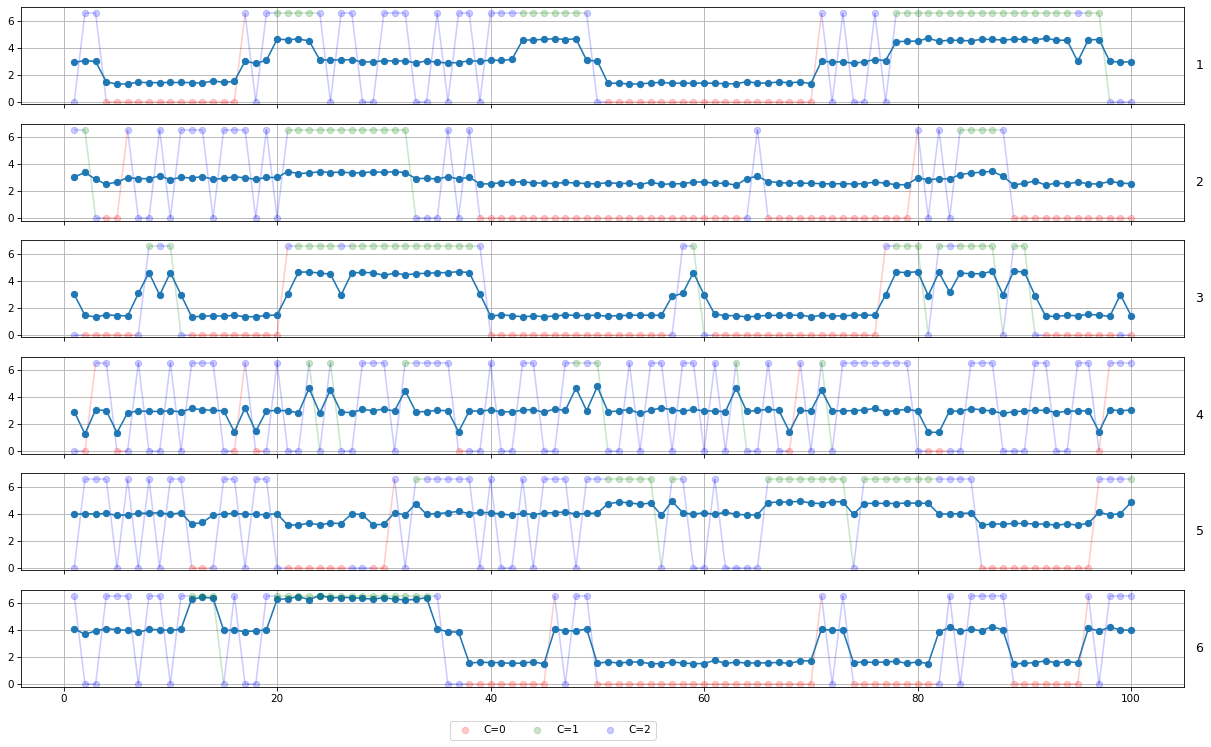

In [ ]:
plot_sim(*hmm_sim(n=1000,T=100,m=6, alpha=[0.9,0.6,0.9,0.9,0.9,0.9], beta=[0.2,0.2,0.9,0.2,0.2,0.2], gamma=[0.1,0.1,0.1,0.9,0.1,0.1],
                 lam0=[1,1,1,1,3,1], lam1=[5,5,5,5,5,7]), mode='o-')

### Plotting X | Z

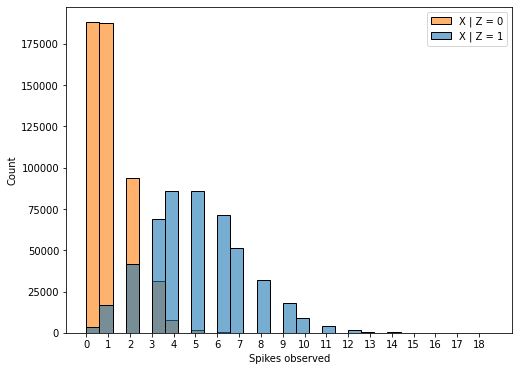

In [65]:
""" Plotting dependencies """ 
X, Z, C = hmm_sim(n=100, T=1000, m=10, alpha=0.9, beta=0.2, gamma=0.1, lam0=1, lam1=5)

X = X.flatten()
Z = Z.flatten()
Z = np.array(Z, dtype=bool)

plt.figure(figsize=(8,6))
ax = sns.histplot([X[Z], X[Z == 0]], color=['green', 'red'], binwidth=0.6, alpha=0.6)
ax.set_xticks(np.linspace(0,X.max(),X.max()+1))
plt.legend(labels=['X | Z = 0', 'X | Z = 1'])
ax.set(xlabel='Spikes observed', ylabel='Count')
plt.savefig('condProb1.png', dpi=400)


# Logistic regression model
Fit (multiclass) logistic regression model(s) of $C_t$ given $X$ for one or more values of $t$ using (lots of) simulated data.

We estimate predict $C_t$ given $X_t$ for each t. The model is only trained with data with same probability distributions.

### Final model

accuracy of final model (same as (3) but with more training data): 0.87282


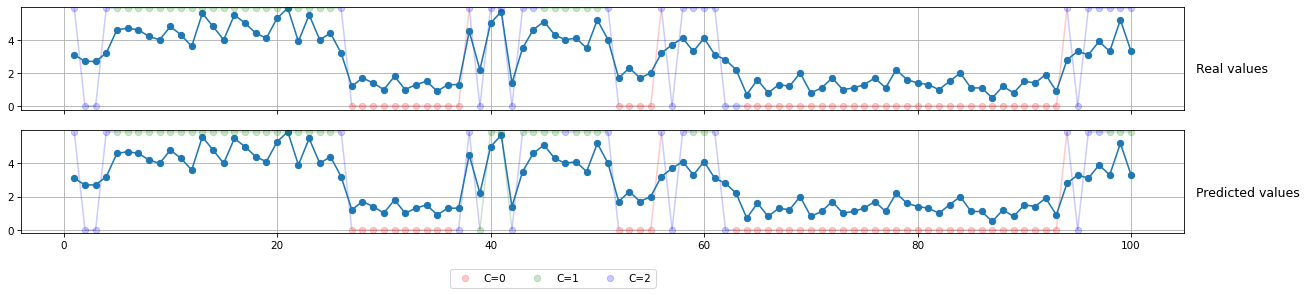

In [ ]:
def logReg_train(X,C):
    m,T,n = np.shape(X)
    C_labels = np.unique(C)
    clf_list = []
    for t in range(T):
        if t-1 < 0:
            X_ = np.append(X[:,t],np.reshape(X[:,t:t+2], (m,2*n)), axis=1)
        elif t+2 > T:
            X_ = np.append(np.reshape(X[:,t-1:t+1], (m,2*n)), X[:,t], axis=1)
        else:
            X_ = np.reshape(X[:,t-1:t+2], (m,3*n))

        if len(set(C[:,t])) < len(C_labels):
            clf_list += [DummyClassifier(strategy="most_frequent").fit(X_, C[:,t])]
        else:
            clf_list += [SGDClassifier(loss="log").fit(X_, C[:,t])]
    return clf_list
def logReg_predict(clf_list,X):
    m,T,n = np.shape(X)
    C = np.zeros((m,T))
    for t in range(T):
        if t-1 < 0:
            X_ = np.append(X[:,t],np.reshape(X[:,t:t+2], (m,2*n)), axis=1)
        elif t+2 > T:
            X_ = np.append(np.reshape(X[:,t-1:t+1], (m,2*n)), X[:,t], axis=1)
        else:
            X_ = np.reshape(X[:,t-1:t+2], (m,3*n))

        C[:,t] = clf_list[t].predict(X_)
    return C
def logReg_accuracy(clf_list,X,C):
    C_pred = predict_Tobias_3(clf_list,X)   
    return np.mean(C_pred == C)


# final model
m_train = 1000#0
m_test = 1000
T_ = 100
n_ = 10

X_train, _, C_train = hmm_sim(n=n_,T=T_,m=m_train)
X_test, _, C_test = hmm_sim(n=n_,T=T_,m=m_test)

clf_list_final = logReg_train(X_train,C_train) # 2 min
acc = logReg_accuracy(clf_list_final,X_test,C_test)
print(f'accuracy of final model (same as (3) but with more training data): {acc}')

# plotting for a sigle simulation - only C is predicted, not Z
X4, Z4, C4 = hmm_sim(n=n_,T=T_,m=1)
C4_p = logReg_predict(clf_list_final,X4)
plot_sim(np.array([X4[0],X4[0]]),np.array([Z4[0],Z4[0]]),np.array([C4[0],C4_p[0]]), titles=['Real values', 'Predicted values'])

# Part 2: Inference of hidden nodes

This part consist of computing $P(C_t|X=x)$ for all $t$ and $P(Z_{t,i}|X=x)$ for all $t$ and $i$.

## Brute force

First we have a simple brute force algorithm. This only works for very small problem sizes.

We have 
$$P(C_1,...,C_T,Z_{1,1},...,Z_{T,n},X_{1,1},...,X_{T,n})=P(\mathbf{C,Z,X}) = P(C_1) \prod_{t=2}^TP(C_t|C_{t-1}) \prod_{t=1}^T\prod_{i=1}^n\left(P(Z_{t,i}|C_t)P(X_{t,i}|Z_{t,i})\right)$$
We then compute $P(\mathbf{C,Z \ | \ X=x})$ by computing the equation above for fixed $X$ and dividing by its sum. We only need to compute for $C_1=2$, since $P(C_1)=0$ for $C_1=0$ and $C_1=1$.

In [ ]:
def brute(X, alpha=0.9, beta=0.2, gamma=0.1, lam0=1, lam1=5):
    # factors given by BN
    Pc_c = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1-beta]])  # Gamma matrix
    Pz_c = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]])  # P(Z|C)
    Px_z = np.array([[np.exp(-lam0)*lam0**x/np.math.factorial(x) for x in range(X.max()+1)], 
                    [np.exp(-lam1)*lam1**x/np.math.factorial(x) for x in range(X.max()+1)]])
    T,n = X.shape
    
    # set up data frame
    df = pd.DataFrame(product(*[[0,1,2]]*(T-1) + [[0,1]] * (T*n)), columns=range(1,T+T*n))
    df.insert(0, 0, 2)
    
    # compute P(C,Z,X) for fixed X for every combination of all Cs and Zs
    df['p'] = [np.product([np.product([Pz_c[v[t], v[T+n*t+i]] * Px_z[v[T+n*t+i], X[t,i]] for i in range(n)]
                ) for t in range(T)]) * np.product([Pc_c[v[t-1], v[t]] for t in range(1,T)]) for _,v in df.iterrows()]

    # Normalizing the p, such that sum over p = 1. 
    df['p'] = df['p'] / df['p'].sum()
    
    return df

n1=3; T1 = 3; m1=1
X1,Z1,C1 = hmm_sim(n=n1,T=T1,m=m1)
df1 = brute(X1[0]) 

# renamning:
df1 = df1.rename(columns=lambda x: x if x == 'p' else (f'C_{x+1}' if x < T1 else f'Z_{x-T1-(x%n1)-int((x-T1)/n1)*(n1-1)+1},{x%n1+1}'))
df1

,C_1,C_2,C_3,"Z_1,1","Z_1,2","Z_1,3","Z_2,1","Z_2,2","Z_2,3","Z_3,1","Z_3,2","Z_3,3",p
0,2,0,0,0,0,0,0,0,0,0,0,0,5.527020e-03
1,2,0,0,0,0,0,0,0,0,0,0,1,2.811970e-04
2,2,0,0,0,0,0,0,0,0,0,1,0,2.811970e-04
3,2,0,0,0,0,0,0,0,0,0,1,1,1.430639e-05
4,2,0,0,0,0,0,0,0,0,1,0,0,2.811970e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,2,2,2,1,1,1,1,1,1,0,1,1,8.932029e-08
4604,2,2,2,1,1,1,1,1,1,1,0,0,1.950689e-07
4605,2,2,2,1,1,1,1,1,1,1,0,1,8.932029e-08
4606,2,2,2,1,1,1,1,1,1,1,1,0,8.932029e-08


From this we can compute the marginal distributions, here $P(C_2|X=x)$ is computed.

In [ ]:
df1[['C_2', 'p']].groupby(['C_2']).sum().reset_index()

,C_2,p
0,0,0.467921
1,1,0.002035
2,2,0.530045


## Variable elimination

A much better algorithm is variable elimination, which is implemented below. This can also be seen as a message passing algorithm.

First $tau_z$ is computed with shape (T,n,3), where each length-3 array in 3rd dimension represent a factor where a $Z_{t,i}$ is eliminated and depends on $C_{t}$. These factors are renormalized by dividing by their sum over $C_{t}=1,2,3$.

Next $tau_c$ is computed with shape (2,T,3), the first dimension is split into 2 parts: in the 1st index we eliminate Cs from left to right, and in the 2nd index we eliminate Cs from right to left. From left to right we start by eliminating $C_1$, which requires the factors: $P(C_1)$, $P(C_2 | C_1)$ and the $tau_z$ factors depending on $C_1$, this computes a new factor stored in $tau_c$ which depends on $C_2$. Next we eliminate $C_2$ which requires the factors: $P(C_3 | C_2)$, the $tau_z$ factors depending on $C_2$ and the $tau_c$ factor we just calculated depending on $C_2$, this computes a new factor stored in $tau_c$ which depends on $C_3$. This continues, and it is the same way it is done from right to left: here we eliminate $C_t$ with factors: $P(C_{t} | C_{t-1})$, the $tau_z$ factors depending on $C_t$ and the $tau_c$ factor we calculated prior this depending on $C_t$, the new factor depends on $C_{t-1}$. Furthermore, we renormalize the computed factor at each step.

Finally we can compute $P(C_t | X=x)$ and $P(Z_t | X=x)$. We compute all of these factors. To compute $P(C_t | X=x)$ we eliminate all $Z$s and all $C$s other than $C_t$, so we need the $tau_c$ from left to right depending on $C_t$, the $tau_c$ from right to left depending on $C_t$, and we need all of the $tau_z$ factors depending on $C_t$. To compute $P(Z_{t,i} | X=x)$ we eliminate all $Z$s other than $Z_{t,i}$ and all $C$s. The last factor we eliminate is $C_t$, which gives us $P(Z_{t,i} | X=x)$, so for this we need the $tau_c$ factor from left to right depending on $C_t$, the $tau_c$ factor from right to left depending on $C_t$, all of the $tau_z$ factors depending on $C_t$ except for the one computed with $Z_{t,i}$, and we need $P(Z_{t,i} | C_t)$ and $P(X_{t,i} | Z_{t,i})$.

In [ ]:
def VE(X, alpha=0.9, beta=0.2, gamma=0.1, lam0=1, lam1=5):
    Pc_c = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1-beta]])
    Pz_c = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]])
    Px_z = np.array([[np.exp(-lam0)*lam0**x/np.math.factorial(x) for x in range(X.max()+1)], [np.exp(-lam1)*lam1**x/np.math.factorial(x) for x in range(X.max()+1)]])
    T,n = X.shape
    
    # factors where Z_{t,i} is eliminated, shape = (T,n,|{0,1,2}|=3)
    tau_z = np.array([[[sum(Pz_c[c, z] * Px_z[z, X[t,i]] for z in [0,1]) for c in [0,1,2]] for i in range(n)] for t in range(T)])
    tau_z = tau_z / tau_z.sum(axis=2)[:, :, np.newaxis] # renormalize
    
    # factors where in 1st dim C_{0:t} is eliminated and in 2nd dim C_{t:T} is eliminated. (Both directions)
    tau_c = np.ones(shape=(2,T,3))  # T-1?
    
    # some initialization
    tau_c[0,-1] = np.array([0,0,1])  # C_1 = 2
    
    # elimination of C
    for t in range(T-1):
        # tau_c[0,_]: Forward pass. tau_c[1,_]: Backward pass
        tau_c[0,t] = np.array([sum(np.prod(tau_z[t,:,c_]) * Pc_c[c_, c] * tau_c[0,t-1,c_] for c_ in [0,1,2]) for c in [0,1,2]])
        tau_c[1,T-2-t] = np.array([sum(np.prod(tau_z[T-1-t,:,c_]) * Pc_c[c, c_] * tau_c[1,T-1-t,c_] for c_ in [0,1,2]) for c in [0,1,2]])
        
        # renormalization
        tau_c[0,t] = tau_c[0,t] / tau_c[0,t].sum()
        tau_c[1,T-2-t] = tau_c[1,T-2-t] / tau_c[1,T-2-t].sum()
    
    # compute P(C_t | X=x) for all t
    C_final = np.array([[np.prod(tau_z[t,:,c]) * tau_c[0,t-1,c] * tau_c[1,t,c] for c in [0,1,2]] for t in range(T)])
    C_final = C_final / C_final.sum(axis=1)[:, np.newaxis]
    
    # compute P(Z_{t,i} | X=x) for all t and i
    Z_final = np.array([[[sum(np.prod(np.append(tau_z[t,:i,c], tau_z[t,i+1:,c])) * tau_c[0,t-1,c] * tau_c[1,t,c] * Pz_c[c,z] * Px_z[z,X[t,i]
                            ] for c in [0,1,2]) for z in [0,1]] for i in range(n)] for t in range(T)])
    Z_final = Z_final / Z_final.sum(axis=2)[:, :, np.newaxis]
    
    return C_final, Z_final
    
C_, Z_ = VE(X1[0])
print(C_)
print(Z_)

[[0.         0.         1.        ]
 [0.46792069 0.00203453 0.53004478]
 [0.55520662 0.01899212 0.42580126]]
[[[0.0171714  0.9828286 ]
  [0.91610478 0.08389522]
  [0.98201379 0.01798621]]

 [[0.80923379 0.19076621]
  [0.94989924 0.05010076]
  [0.94989924 0.05010076]]

 [[0.8241023  0.1758977 ]
  [0.8241023  0.1758977 ]
  [0.8241023  0.1758977 ]]]


In [ ]:
# compare result with brute force
for i in range(len(df1.columns)-1):
    var = df1.columns[i]
    print(df1[[var, 'p']].groupby([var]).sum().reset_index(),'\n')

   C_1    p
0    2  1.0 

   C_2         p
0    0  0.467921
1    1  0.002035
2    2  0.530045 

   C_3         p
0    0  0.555207
1    1  0.018992
2    2  0.425801 

   Z_1,1         p
0      0  0.017171
1      1  0.982829 

   Z_1,2         p
0      0  0.916105
1      1  0.083895 

   Z_1,3         p
0      0  0.982014
1      1  0.017986 

   Z_2,1         p
0      0  0.809234
1      1  0.190766 

   Z_2,2         p
0      0  0.949899
1      1  0.050101 

   Z_2,3         p
0      0  0.949899
1      1  0.050101 

   Z_3,1         p
0      0  0.824102
1      1  0.175898 

   Z_3,2         p
0      0  0.824102
1      1  0.175898 

   Z_3,3         p
0      0  0.824102
1      1  0.175898 



## 2nd implementation of VE: handles multiple simulations at the same time

In [ ]:
def VE_multi_sim(X, alpha=0.9, beta=0.2, gamma=0.1, lam0=1, lam1=5):
    m,T,n = X.shape
    alpha, beta, gamma, lam0, lam1 = check_values(n, T, m, alpha, beta, gamma, lam0, lam1)

    Pc_c = np.array([[1-gamma, np.zeros(m), gamma], [np.zeros(m), 1-gamma, gamma], [beta/2, beta/2, 1-beta]]) # shape = (3,3,m)
    Pz_c = np.array([[alpha, 1-alpha], [1-alpha, alpha], [np.ones(m)*0.5, np.ones(m)*0.5]]) # shape = (3,2,m)
    Px_z = np.array([[[np.exp(-l0)*l0**x/np.math.factorial(x) for x in range(X.max()+1)] for l0 in lam0],
                    [[np.exp(-l1)*l1**x/np.math.factorial(x) for x in range(X.max()+1)] for l1 in lam1]]) # shape = (2,m,x.max)

    # factors where Z_{t,i} is eliminated, shape = (m,T,n,|{0,1,2}|=3)
    tau_z = np.array([[[[sum(Pz_c[c,z,j] * Px_z[z,j,X[j,t,i]] for z in [0,1]) for c in [0,1,2]] for i in range(n)] for t in range(T)] for j in range(m)])
    tau_z /= tau_z.sum(axis=3)[:,:,:, np.newaxis] # renormalize
    
    # factors where in 1st dim C_{0:t} is eliminated and in 2nd dim C_{t:T} is eliminated. (Both directions)
    tau_c = np.ones(shape=(m,2,T,3))
    
    # some initialization
    tau_c[:,0,-1] = np.array([0,0,1])  # C_1 = 2
    
    # elimination of C
    for t in range(T-1):
        # tau_c[0,_]: Forward pass. tau_c[1,_]: Backward pass
        tau_c[:,0,t] = np.array([[sum(np.prod(tau_z[j,t,:,c_]) * Pc_c[c_,c,j] * tau_c[j,0,t-1,c_] for c_ in [0,1,2]) for c in [0,1,2]] for j in range(m)])
        tau_c[:,1,T-2-t] = np.array([[sum(np.prod(tau_z[j,T-1-t,:,c_]) * Pc_c[c,c_,j] * tau_c[j,1,T-1-t,c_] for c_ in [0,1,2]) for c in [0,1,2]] for j in range(m)])
        
        # renormalization
        tau_c[:,0,t] /= tau_c[:,0,t].sum(axis=1)[:,np.newaxis]
        tau_c[:,1,T-2-t] /= tau_c[:,1,T-2-t].sum(axis=1)[:,np.newaxis]
    
    # compute P(C_t | X=x) for all t, shape = (m,T,3)
    C_final = np.array([[[np.prod(tau_z[j,t,:,c]) * tau_c[j,0,t-1,c] * tau_c[j,1,t,c] for c in [0,1,2]] for t in range(T)] for j in range(m)])
    C_final /= C_final.sum(axis=2)[:,:, np.newaxis]
    
    # compute P(Z_{t,i} | X=x) for all t and i, shape = (m,T,n,2)
    Z_final = np.array([[[[sum(np.prod(np.append(tau_z[j,t,:i,c], tau_z[j,t,i+1:,c])) * tau_c[j,0,t-1,c] * tau_c[j,1,t,c] * Pz_c[c,z,j] *
                 Px_z[z,j,X[j,t,i]] for c in [0,1,2]) for z in [0,1]] for i in range(n)] for t in range(T)] for j in range(m)])
    Z_final /= Z_final.sum(axis=3)[:,:,:, np.newaxis]
    
    return C_final, Z_final

n1=3; T1 = 3; m1=2
alpha1 = [0.9,0.8]; beta1 = [0.2,0.3]; gamma1 = [0.1,0.2]; lam01 = [1,2]; lam11 = [5,6]
X1,Z1,C1 = hmm_sim(n=n1,T=T1,m=m1,alpha=alpha1,beta=beta1,gamma=gamma1,lam0=lam01,lam1=lam11)

C_1, Z_1 = VE_multi_sim(X1,alpha1,beta1,gamma1,lam01,lam11)

for i in range(m1):
    C_, Z_ = VE(X1[i],alpha1[i],beta1[i],gamma1[i],lam01[i],lam11[i])
    print(C_)
    print(C_1[i])
    print(Z_)
    print(Z_1[i])


[[0.         0.         1.        ]
 [0.20753804 0.00225252 0.79020945]
 [0.19782859 0.04643466 0.75573674]]
[[0.         0.         1.        ]
 [0.20753804 0.00225252 0.79020945]
 [0.19782859 0.04643466 0.75573674]]
[[[0.68592235 0.31407765]
  [0.68592235 0.31407765]
  [0.91610478 0.08389522]]

 [[0.73995254 0.26004746]
  [0.98504687 0.01495313]
  [0.98504687 0.01495313]]

 [[0.97943425 0.02056575]
  [0.14823695 0.85176305]
  [0.3896043  0.6103957 ]]]
[[[0.68592235 0.31407765]
  [0.68592235 0.31407765]
  [0.91610478 0.08389522]]

 [[0.73995254 0.26004746]
  [0.98504687 0.01495313]
  [0.98504687 0.01495313]]

 [[0.97943425 0.02056575]
  [0.14823695 0.85176305]
  [0.3896043  0.6103957 ]]]
[[0.         0.         1.        ]
 [0.03474538 0.25027739 0.71497723]
 [0.07962529 0.35895932 0.5614154 ]]
[[0.         0.         1.        ]
 [0.03474538 0.25027739 0.71497723]
 [0.07962529 0.35895932 0.5614154 ]]
[[[0.18346267 0.81653733]
  [0.94791499 0.05208501]
  [0.94791499 0.05208501]]

 [[0

### Correctness

In [ ]:
# computing mean of 1(Z=z) - P(Z=z | X=x), which should be 0

def check_ve_z(Z, Z_real, val=0):
    w = []
    m,T,n = Z_real.shape
    w = [int(Z_real[j,t,i]==val) - Z[j,t,i,val] for j in range(m) for t in range(T) for i in range(n)]
    return np.mean(w)

def check_ve_c(C, C_real, val=0):
    w = []
    m,T = C_real.shape
    w = [int(C_real[j,t]==val) - C[j,t,val] for j in range(m) for t in range(T)]
    return np.mean(w)

def predict(C,Z):
    return C.argmax(axis=1), Z.argmax(axis=2)

def predict_multi_sim(C,Z):
    return C.argmax(axis=2), Z.argmax(axis=3)


In [ ]:
X1,Z1,C1 = hmm_sim(n=10,T=100,m=100)

C_ve_p, Z_ve_p = VE_multi_sim(X1)
print(f'mean of 1(Z=z) - P(Z=z|X=x): {check_ve_z(Z_ve_p,Z1)}')
print(f'mean of 1(C=c) - P(C=c|X=x): {check_ve_c(C_ve_p,C1)}')


# comparison with logistic regression (if the predict the same values).
C_ve, Z_ve = predict_multi_sim(C_ve_p, Z_ve_p)
C_log = logReg_predict(clf_list_final,X1)
err = np.mean(C_log != C_ve)
print(f'Error of VE compared to LogReg: {err}')

mean of 1(Z=z) - P(Z=z|X=x): -0.000259549380571774
mean of 1(C=c) - P(C=c|X=x): -0.0003596592941586488
Error of VE compared to LogReg: 0.1099


# Plotting predicted values

We simulate some data, which we predict Z and C on. We compare the predicted values with the true values by plotting.

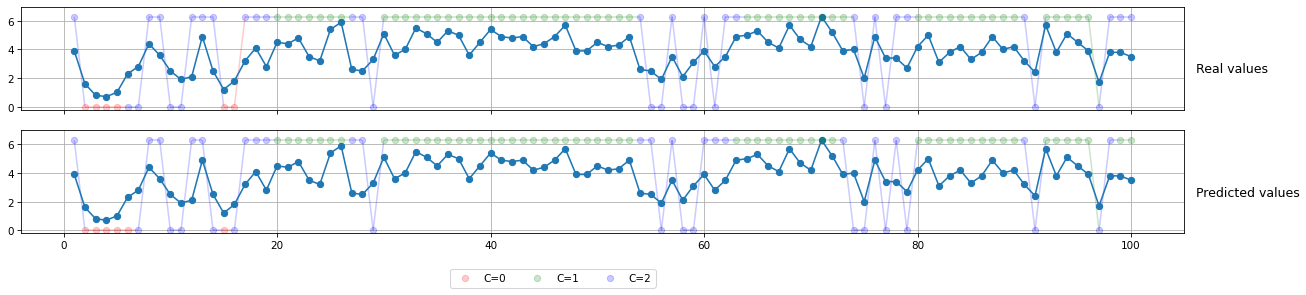

In [ ]:
X4,Z4,C4 = hmm_sim(n=10,T=100,m=1)
X4,Z4,C4 = X4[0],Z4[0],C4[0]
C_,Z_ = predict(*VE(X4))

plot_sim(np.array([X4,X4]),np.array([Z4,Z_]),np.array([C4,C_]), titles=['Real values', 'Predicted values'])

We predict Z and C on the handed out data:

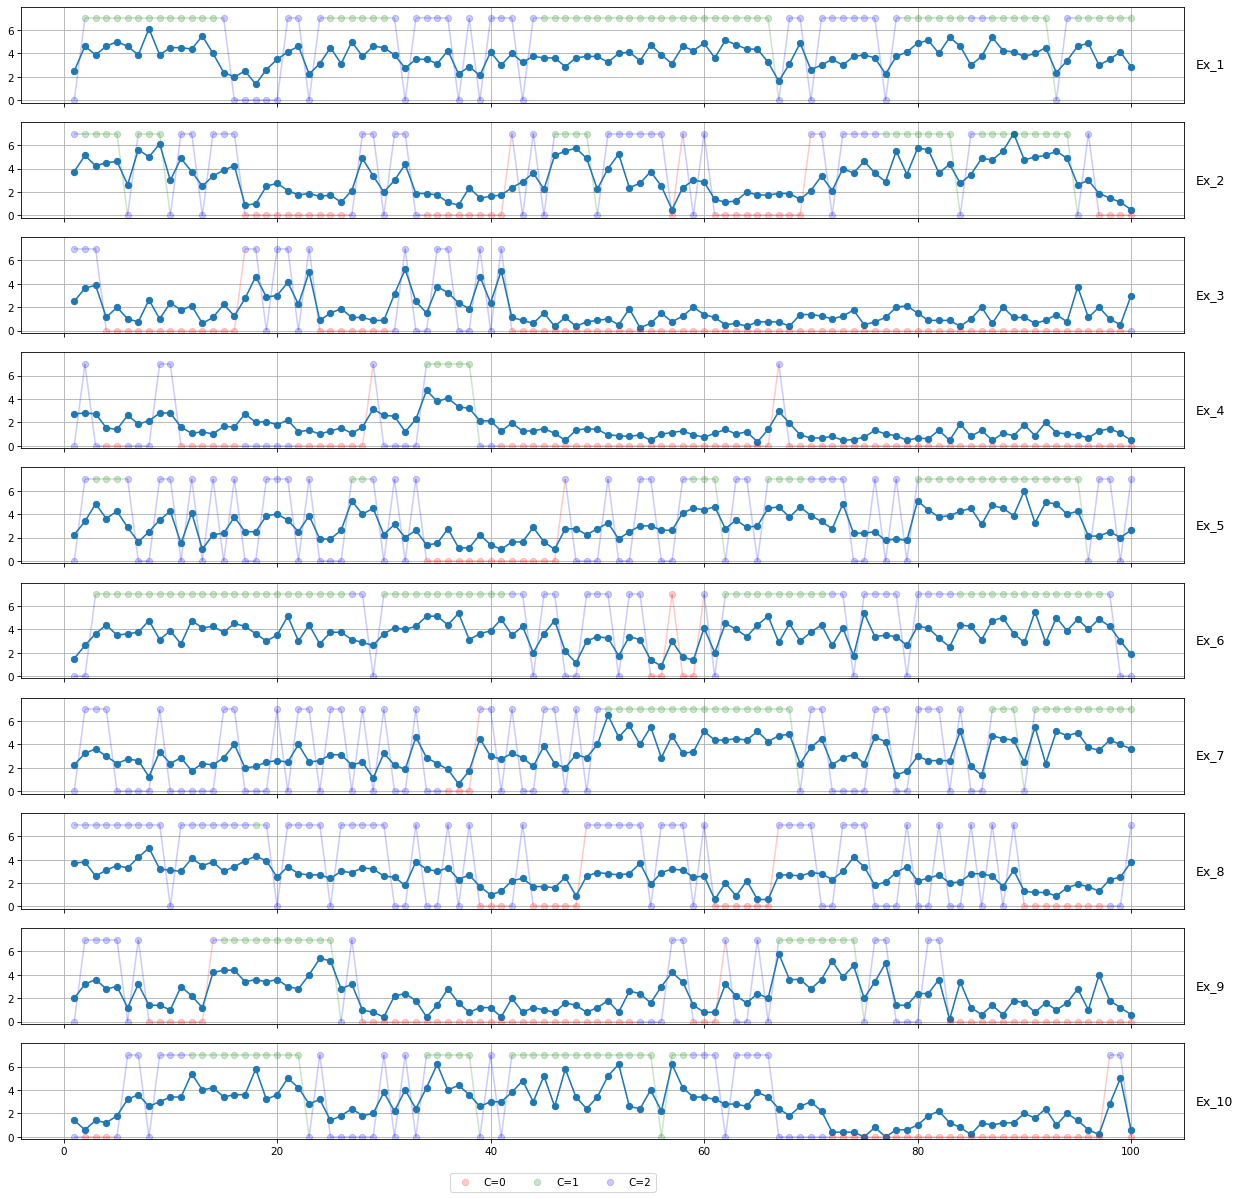

In [ ]:
Xs = []
Zs = []
Cs = []
for i in range(10):
    X = pd.read_csv(f'data/Ex_{i+1}.csv').iloc[:,1:].to_numpy()
    C,Z = predict(*VE(X))
    Xs += [X]
    Zs += [Z]
    Cs += [C]
plot_sim(Xs, Zs, Cs, titles=[f'Ex_{i+1}' for i in range(10)])

## Part 3: Learning the parameters

**Learn:** <br>
*Poisson (X) distribution:* <br>
$\hat\lambda_0$ : Average of $X_{t,i-s}$ for which $Z_{t,i}=0$ <br>
$\hat\lambda_1$ : Average of $X_{t,i-s}$ for which $Z_{t,i}=1$ <br>

*$P(Z|C)$:* <br>
$\hat\alpha$ : Relative frequency of the events $Z_{t,i}=C_t=0$ and $Z_{t,i}=C_t=1$ <br>

*$P(C_{t+1}|C_t)$:* <br>
$\hat\beta$ : Relative frequency of the transition $C_t=2 \rightarrow C_{t+1} \in \{0,1\}$ <br>
$\hat\gamma$ : Relative frequency of the transition $C_{t+1} \in \{0,1\} \rightarrow C_t=2$  <br>

### (Observed: X, Z, C)
When we have X and a guess of Z and C, we can compute the expected parameters.

In [ ]:
def learn_param(X,Z,C): 
    m,T,n = X.shape
    alpha_hat = np.sum(((Z==0) & (C[:,:,None]==0)) | ((Z==1) & (C[:,:,None]==1))) / (np.sum((C==0) | (C==1))*n)     # ((Z=0 and C=0) or (Z=1 and C=1)) / (C=0 or C=1)
    beta_hat = np.sum((C[:,:T-1]==2) & (C[:,1:]!=2)) / np.sum(C[:,:T-1]==2)                                         # (C_t=2 and C_{t+1}!=2) / (C_t=2)
    gamma_hat = np.sum((C[:,:T-1]!=2) & (C[:,1:]==2)) / np.sum(C[:,:T-1]!=2)                                        # (C_t!=2 and C_{t+1}==2) / (C_t!=2)
    lam0_hat = X[Z==0].mean()                                                                                       # mean of X|Z=0
    lam1_hat = X[Z==1].mean()                                                                                       # mean of X|Z=1
    return alpha_hat, beta_hat, gamma_hat, lam0_hat, lam1_hat
    
X,Z,C = hmm_sim(n=10,T=100,m=100,alpha=0.87,beta=0.34,gamma=0.22,lam0=2,lam1=6) 
learn_param(X,Z,C)

(0.8689061444969615,
 0.3372986369268897,
 0.22199488491048594,
 1.9959836950005994,
 6.001261160267446)

### (Observed: X) Hard-assignment EM

Combine inference with Hard-EM

In [ ]:
def predict_multi_sim(C,Z):
    return C.argmax(axis=2), Z.argmax(axis=3)

def hard_EM(X_observed, Z_observed=None, C_observed=None, N=10, trace = False):

    alpha_init = np.random.uniform(0.501,1)
    beta_init = np.random.uniform(0.001,1)
    gamma_init = np.random.uniform(0.001,1)
    lam0_init = np.random.uniform(0.001,2) 
    lam1_init = np.random.uniform(2,10)

    if (len(np.shape(X_observed))==2):
        X_observed = np.array([X_observed])

    m,T,n = X_observed.shape
    alpha,beta,gamma,lam0,lam1 = [alpha_init],[beta_init],[gamma_init],[lam0_init],[lam1_init]

    C_hat = np.zeros(shape = (m,T), dtype=np.int8)
    Z_hat = np.zeros(shape = (m,T,n), dtype=np.int8)
    for iteration in range(N):
        # Predict C and Z 
        C_hat,Z_hat = predict_multi_sim(*VE_multi_sim(X_observed, alpha[-1],beta[-1],gamma[-1],lam0[-1],lam1[-1]))

        if trace and Z_observed is not None and C_observed is not None:
            C_loss = np.mean(C_hat != C_observed)
            Z_loss = np.mean(Z_hat != Z_observed)
            print(f"Error at iteration {iteration}: {np.divide(np.add(C_loss,Z_loss), 2.0)}")
        
        # compute model parameters
        alpha_tmp,beta_tmp,gamma_tmp,lam0_tmp,lam1_tmp = learn_param(X_observed, Z_hat,C_hat)

        # redefine if not in correct range
        if alpha_tmp >= 1: alpha_tmp = 0.999
        if alpha_tmp <= 0.5: alpha_tmp = 0.501
        if pd.isna(alpha_tmp): alpha_tmp = alpha[-1]

        if beta_tmp >= 1: beta_tmp = 0.999
        if beta_tmp <= 0: beta_tmp = 0.001
        if pd.isna(beta_tmp): beta_tmp = beta[-1]

        if gamma_tmp >= 1: gamma_tmp = 0.999
        if gamma_tmp <= 0: gamma_tmp = 0.001
        if pd.isna(gamma_tmp): gamma_tmp = gamma[-1]

        if lam0_tmp <= 0: lam0_tmp = 0.001
        if pd.isna(lam0_tmp): lam0_tmp = lma0[-1]

        if lam1_tmp <= 0: lam1_tmp = 0.001
        if pd.isna(lam1_tmp): lam1_tmp = lam1[-1]

        alpha += [alpha_tmp]; beta += [beta_tmp]; gamma += [gamma_tmp]; lam0 += [lam0_tmp]; lam1 += [lam1_tmp];

        # stop early
        if all(abs(np.array([alpha[-1],beta[-1],gamma[-1],lam0[-1],lam1[-1]]) - np.array([alpha[-2],beta[-2],gamma[-2],lam0[-2],lam1[-2]])) < 0.00001):
            return alpha,beta,gamma,lam0,lam1
    return alpha,beta,gamma,lam0,lam1

    

## Test with simulated data

### Example that went good

Error at iteration 0: 0.3617
Error at iteration 1: 0.21334999999999998
Error at iteration 2: 0.1007
Error at iteration 3: 0.0733
Error at iteration 4: 0.0636
Error at iteration 5: 0.05805
Error at iteration 6: 0.05545
Error at iteration 7: 0.05545


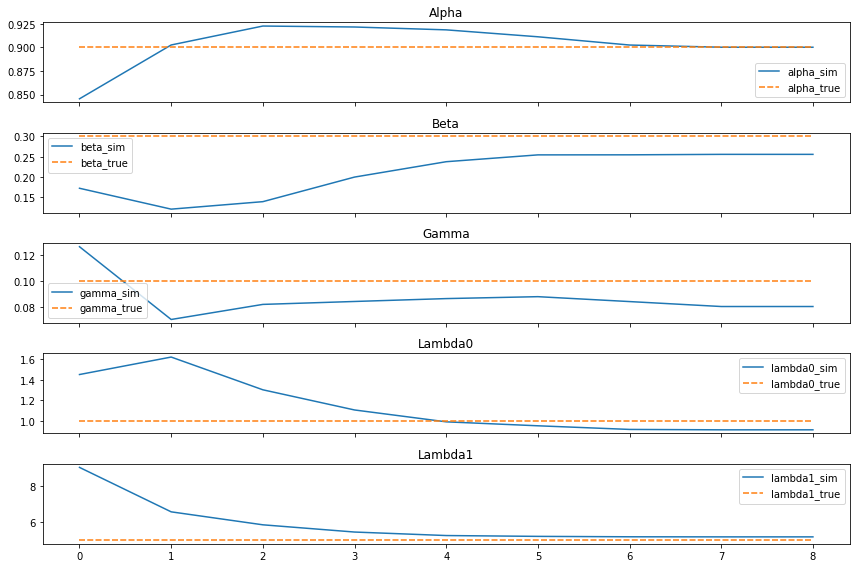

In [ ]:
# eksempel, hvor det går godt
alpha_f=0.9
beta_f=0.3
gamma_f=0.1
lam0_f=1
lam1_f=5
alpha,beta,gamma,lam0,lam1 = hard_EM(*hmm_sim(n=10,T=100,m=10,alpha=alpha_f ,beta=beta_f, gamma=gamma_f, lam0=lam0_f, lam1=lam1_f), N=20, trace=True)

EM = pd.DataFrame(list(zip(alpha,beta,gamma,lam0,lam1)), columns = ['alpha_sim', 'beta_sim', 'gamma_sim', 'lambda0_sim', 'lambda1_sim'])
EM['alpha_true'] = alpha_f
EM['beta_true'] = beta_f
EM['gamma_true'] = gamma_f
EM['lambda0_true'] = lam0_f
EM['lambda1_true'] = lam1_f

fig, axs = plt.subplots(5, figsize=(12,8), sharex=True)
axs[0].set_title('Alpha'); sns.lineplot(data=[EM.alpha_sim, EM.alpha_true], ax = axs [0])
axs[1].set_title('Beta'); sns.lineplot(data=[EM.beta_sim, EM.beta_true], ax = axs [1])
axs[2].set_title('Gamma'); sns.lineplot(data=[EM.gamma_sim, EM.gamma_true], ax = axs [2])
axs[3].set_title('Lambda0'); sns.lineplot(data=[EM.lambda0_sim, EM.lambda0_true], ax = axs [3])
axs[4].set_title('Lambda1'); sns.lineplot(data=[EM.lambda1_sim, EM.lambda1_true], ax = axs [4])
plt.tight_layout()
plt.show()

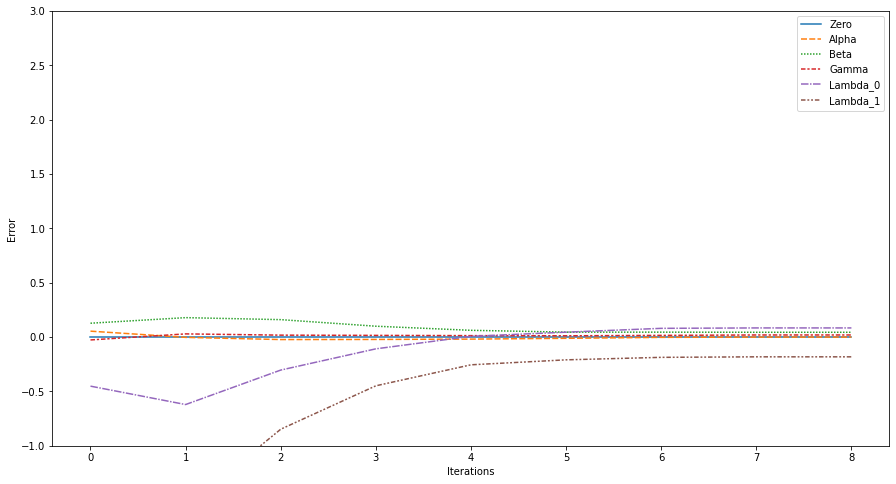

In [ ]:
EM2 = pd.DataFrame(list(zip([0]*len(alpha), [(alpha_f-x) for x in alpha],[(beta_f-x) for x in beta],[(gamma_f-x) for x in gamma],[(lam0_f-x) for x in lam0],[(lam1_f-x) for x in lam1])), columns = ['Zero', 'Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=EM2)
ax.set(ylim=(-1, 3))
ax.set_xlabel('Iterations')
ax.set_ylabel('Error')
plt.show()

We see that the predicted values of the parameters are cose to the correct values.
### Example where it algorithm fail

Error at iteration 0: 0.537
Error at iteration 1: 0.49735
Error at iteration 2: 0.499
Error at iteration 3: 0.504
Error at iteration 4: 0.5045000000000001
Error at iteration 5: 0.5045000000000001


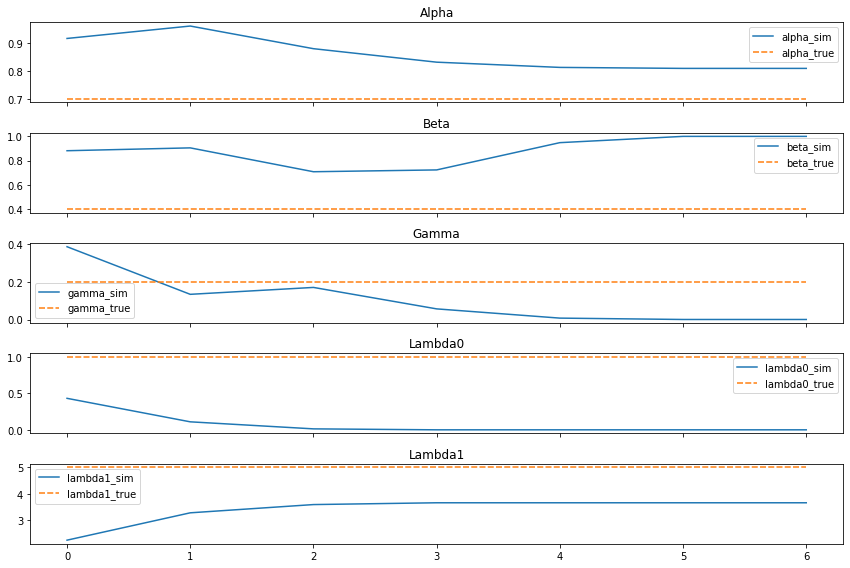

In [ ]:
# eksempel, hvor det går dårligt
alpha_f=0.7
beta_f=0.4
gamma_f=0.2
lam0_f=1
lam1_f=5

alpha,beta,gamma,lam0,lam1 = hard_EM(*hmm_sim(n=10,T=100,m=10,alpha=alpha_f ,beta=beta_f, gamma=gamma_f, lam0=lam0_f, lam1=lam1_f), N=20, trace=True)

EM = pd.DataFrame(list(zip(alpha,beta,gamma,lam0,lam1)), columns = ['alpha_sim', 'beta_sim', 'gamma_sim', 'lambda0_sim', 'lambda1_sim'])
EM['alpha_true'] = alpha_f
EM['beta_true'] = beta_f
EM['gamma_true'] = gamma_f
EM['lambda0_true'] = lam0_f
EM['lambda1_true'] = lam1_f

fig, axs = plt.subplots(5, figsize=(12,8), sharex=True)
axs[0].set_title('Alpha'); sns.lineplot(data=[EM.alpha_sim, EM.alpha_true], ax = axs [0])
axs[1].set_title('Beta'); sns.lineplot(data=[EM.beta_sim, EM.beta_true], ax = axs [1])
axs[2].set_title('Gamma'); sns.lineplot(data=[EM.gamma_sim, EM.gamma_true], ax = axs [2])
axs[3].set_title('Lambda0'); sns.lineplot(data=[EM.lambda0_sim, EM.lambda0_true], ax = axs [3])
axs[4].set_title('Lambda1'); sns.lineplot(data=[EM.lambda1_sim, EM.lambda1_true], ax = axs [4])
plt.tight_layout()
plt.show()

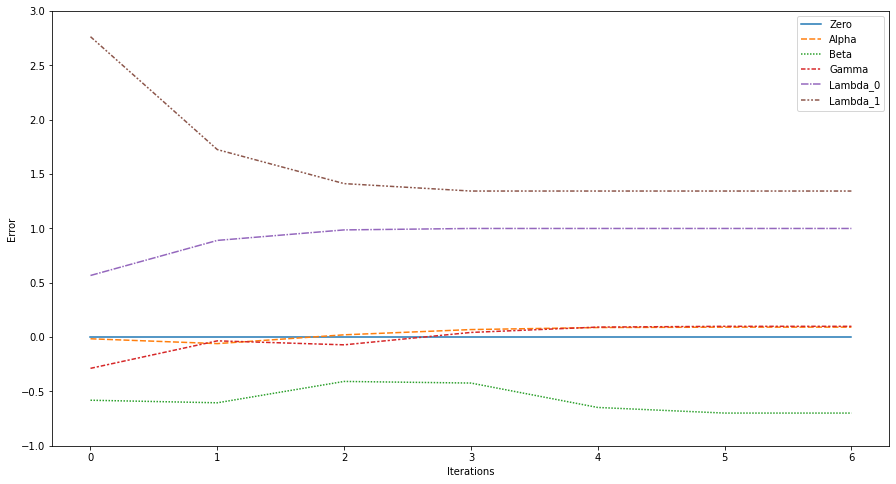

In [ ]:
EM2 = pd.DataFrame(list(zip([0]*len(alpha), [(alpha_f-x) for x in alpha],[(beta_f-x) for x in beta],[(gamma_f-x) for x in gamma],[(lam0_f-x) for x in lam0],[(lam1_f-x) for x in lam1])), columns = ['Zero', 'Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=EM2)
ax.set(ylim=(-1, 3))
ax.set_xlabel('Iterations')
ax.set_ylabel('Error')
plt.show()

We see that the predicted parameters are not close to the correct values.

# Prediction on given data
#### Estimation of parameters with EM

In [ ]:
EM_list = []
for i in range(10):
    X_o = pd.read_csv(f'data/Ex_{i+1}.csv').iloc[:,1:].to_numpy()
    EM_list += [hard_EM(X_observed = X_o, N=15)]

alphas = [x[0][-1] for x in EM_list]
betas = [x[1][-1] for x in EM_list]
gammas = [x[2][-1] for x in EM_list]
lam0s = [x[3][-1] for x in EM_list]
lam1s = [x[4][-1] for x in EM_list]

for i in range(len(EM_list)):
    print(f'Model {i}')
    print(f'alpha: {alphas[i]}')
    print(f'beta : {betas[i]}')
    print(f'gamma: {gammas[i]}')
    print(f'lam_0: {lam0s[i]}')
    print(f'lam_1: {lam1s[i]}\n')

Model 0
alpha: 0.7714646464646465
beta : 0.999
gamma: 0.001
lam_0: 0.6290322580645161
lam_1: 4.734527687296417

Model 1
alpha: 0.9513888888888888
beta : 0.17391304347826086
gamma: 0.1320754716981132
lam_0: 1.4891944990176817
lam_1: 6.096219931271477

Model 2
alpha: 0.9626623376623377
beta : 0.18181818181818182
gamma: 0.05194805194805195
lam_0: 0.9110787172011662
lam_1: 6.06140350877193

Model 3
alpha: 0.8914285714285715
beta : 0.2
gamma: 0.07246376811594203
lam_0: 0.5032198712051518
lam_1: 4.135593220338983

Model 4
alpha: 0.8618421052631579
beta : 0.08196721311475409
gamma: 0.13157894736842105
lam_0: 1.0507614213197969
lam_1: 5.032019704433497

Model 5
alpha: 0.999
beta : 0.999
gamma: 0.0425531914893617
lam_0: 0.001
lam_1: 3.6594387755102042

Model 6
alpha: 0.7160326086956522
beta : 0.5
gamma: 0.03296703296703297
lam_0: 1.3141592920353982
lam_1: 5.818965517241379

Model 7
alpha: 0.7690476190476191
beta : 0.08771929824561403
gamma: 0.11904761904761904
lam_0: 0.655831739961759
lam_1: 4.

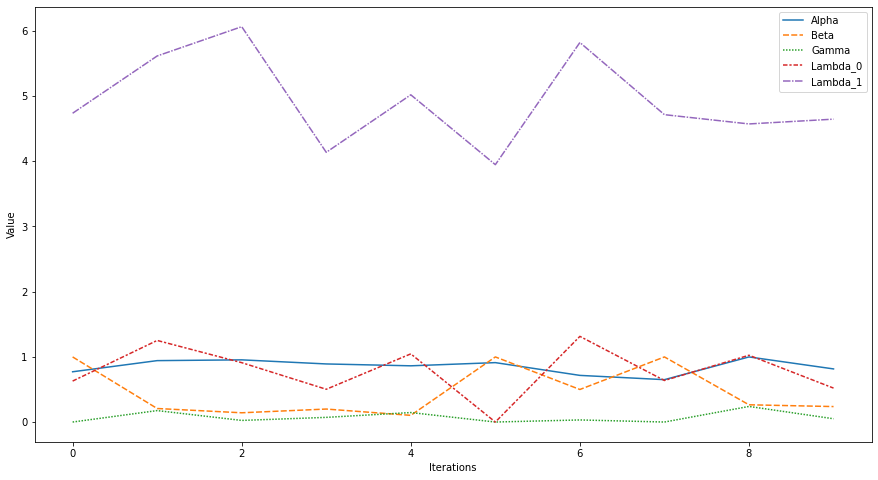

In [ ]:
def extract(i):
    X_o = pd.read_csv(f'data/Ex_{i}.csv').iloc[:,1:].to_numpy()
    alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = hard_EM(X_observed = X_o, N=15)
    if len(alpha_Ex) < 10:
        alpha_Ex += [alpha_Ex[-1]]*(10-len(alpha_Ex))
        beta_Ex += [beta_Ex[-1]]*(10-len(beta_Ex))
        gamma_Ex += [gamma_Ex[-1]]*(10-len(gamma_Ex))
        lam0_Ex += [lam0_Ex[-1]]*(10-len(lam0_Ex))
        lam1_Ex += [lam1_Ex[-1]]*(10-len(lam1_Ex))
    return alpha_Ex[:10], beta_Ex[:10], gamma_Ex[:10], lam0_Ex[:10], lam1_Ex[:10]
​
​# this can be done in a loop
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(1)
EX1 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(2)
EX2 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(3)
EX3 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(4)
EX4 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(5)
EX5 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(6)
EX6 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(7)
EX7 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(8)
EX8 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(9)
EX9 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])
​
alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex = extract(10)
EX10 = pd.DataFrame(list(zip(alpha_Ex, beta_Ex, gamma_Ex, lam0_Ex, lam1_Ex)), columns = ['Alpha', 'Beta', 'Gamma', 'Lambda_0', 'Lambda_1'])


fig, axs = plt.subplots(5, 2, figsize=(15,8), sharex=True)
axs[0,0].set_title('Ex_1'); sns.lineplot(data=EX1, ax = axs [0,0], legend=None)
axs[0,1].set_title('Ex_2'); sns.lineplot(data=EX2, ax = axs [0,1], legend=None)
axs[1,0].set_title('Ex_3'); sns.lineplot(data=EX3, ax = axs [1,0], legend=None)
axs[1,1].set_title('Ex_4'); sns.lineplot(data=EX4, ax = axs [1,1], legend=None)
axs[2,0].set_title('Ex_5'); sns.lineplot(data=EX5, ax = axs [2,0], legend=None)
axs[2,1].set_title('Ex_6'); sns.lineplot(data=EX6, ax = axs [2,1], legend=None)
axs[3,0].set_title('Ex_7'); sns.lineplot(data=EX7, ax = axs [3,0], legend=None)
axs[3,1].set_title('Ex_8'); sns.lineplot(data=EX8, ax = axs [3,1], legend=None)
axs[4,0].set_title('Ex_9'); sns.lineplot(data=EX9, ax = axs [4,0], legend=None)
axs[4,1].set_title('Ex_10'); sns.lineplot(data=EX10, ax = axs [4,1])
plt.tight_layout()
#fig.savefig('3_3_non_sim.png', dpi=300)
plt.show()

Could be trained for longer: it does not converge
#### Use the predicted parameters to do inference of C and Z for each datafile

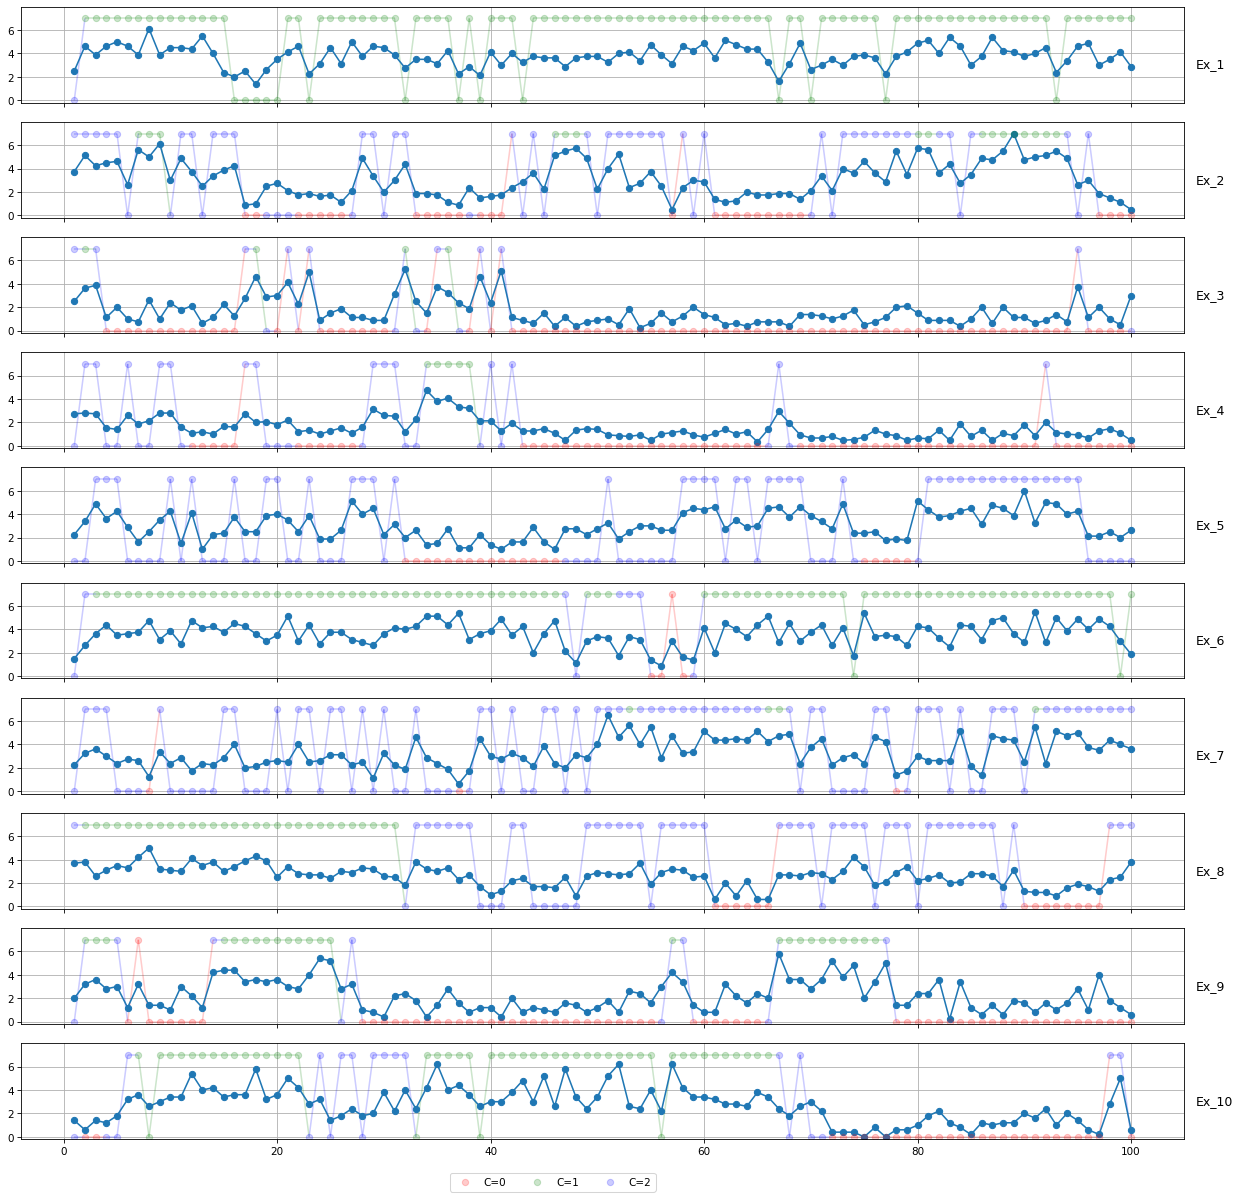

In [ ]:
Xs, Zs, Cs = [],[],[]
for i in range(10):
    Xs += [pd.read_csv(f'data/Ex_{i+1}.csv').iloc[:,1:].to_numpy()]
    C_,Z_ = predict(*VE(Xs[i], alphas[i], betas[i], gammas[i], lam0s[i], lam1s[i]))
    Cs += [C_]; Zs += [Z_]
plot_sim(Xs, Zs, Cs, titles=[f'Ex_{i+1}' for i in range(10)])